# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# magic word for producing visualizations in notebook
%matplotlib inline

The scikit-learn version is 0.19.1.


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(feat_info.shape)
feat_info.head(10)

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
# Identify missing or unknown data values and convert them to NaNs.

for attribute in feat_info['attribute']:
    missing_or_unknown_vals=feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0]

    missing_or_unknown_list=missing_or_unknown_vals.strip('[ ]').split(',')

    null_vals=[]
    for item in missing_or_unknown_list: 
        if item.lstrip('-').isnumeric():
            null_vals.append(float(item))
        else:
            null_vals.append(item)

    azdias[attribute].replace(to_replace=null_vals,value=np.nan,inplace=True)


In [8]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
sum_of_missings=azdias.isnull().sum()
pc_of_missings=100 * azdias.isnull().sum() / len(azdias)
missings_tab = pd.concat([sum_of_missings, pc_of_missings], axis=1)
missings_df = missings_tab.rename(columns = {0 : 'Count', 1 : 'Percent'})

missings_df = missings_df[missings_df.iloc[:,1] != 0].sort_values(
        'Percent', ascending=False).round(2)


In [10]:
missings_df.head(10)

,Count,Percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17e1f1cd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f17e1693550>]], dtype=object)

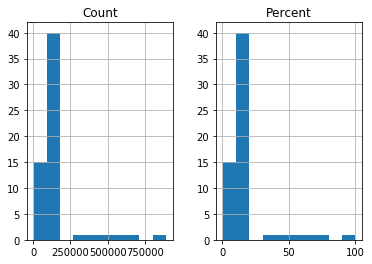

In [11]:

# Investigate patterns in the amount of missing data in each column.

missings_df.hist()

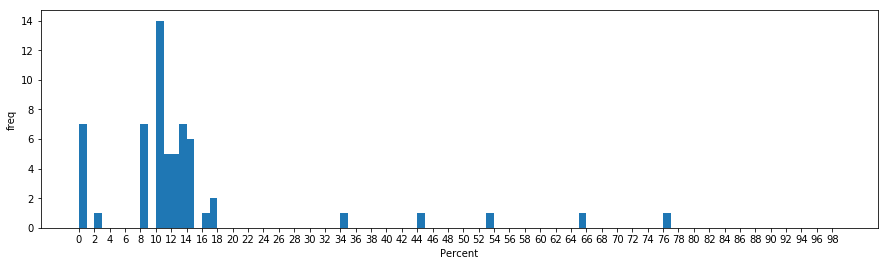

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(15,4))
plt.hist(missings_df.Percent, bins=np.arange(0,100,1))
plt.xlabel('Percent')
plt.ylabel('freq')
plt.xticks(np.arange(0,100,2));


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_cols = missings_df[missings_df.Percent > 20.].index
outlier_cols

azdias.drop(outlier_cols, axis=1, inplace=True)
azdias.shape



(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Most of the variables in the general population dataset have between 8-15% missing data.

There are six columns where over 20% of the data was missing. These columns are:
* TITEL_KZ - Academic title flag
* AGER_TYP - Best-ager typology
* KK_KUNDENTYP - Consumer pattern over past 12 months
* KBA05_BAUMAX - Most common building type within the microcell
* GEBURTSJAHR - Year of birth
* ALTER_HH - Birthdate of head of household

We plan to run PCA on this dataset and missing values will have to be imputed. Having too much imputed data will lead to less meaninful results. Therefore we've removed these from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

sum_of_missings=azdias.isnull().sum(axis=1)
pc_of_missings=100 * azdias.isnull().sum(axis=1) / (azdias.shape[1])
missings_tab = pd.concat([sum_of_missings, pc_of_missings], axis=1)
missings_df = missings_tab.rename(columns = {0 : 'Count', 1 : 'Percent'})

missings_df = missings_df[missings_df.iloc[:,1] != 0].sort_values(
        'Percent', ascending=False).round(2)

missings_df = missings_df[missings_df.iloc[:,1] != 0].sort_values(
        'Percent', ascending=False).round(2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17e1d86ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f17e13ee4a8>]], dtype=object)

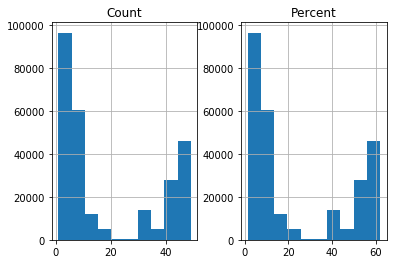

In [15]:
missings_df.hist()

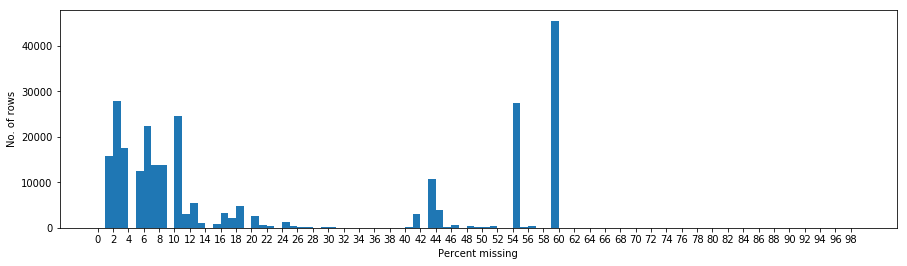

In [16]:
plt.figure(figsize=(15,4))
plt.hist(missings_df.Percent, bins=np.arange(0,100,1))
plt.xlabel('Percent missing')
plt.ylabel('No. of rows')
plt.xticks(np.arange(0,100,2));

In [17]:
azdias_copy=azdias.copy()

azdias_copy.shape
#891221

(891221, 79)

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_copy=azdias.copy()

high_missings=missings_df[missings_df.Percent >= 32.].index

above_threshold=azdias_copy.take(azdias_copy.index[high_missings])
below_threshold=azdias_copy.drop(azdias_copy.index[high_missings])


below_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [19]:
above_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
643174,3.0,1,NaN,2,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732775,3.0,2,NaN,3,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472919,1.0,1,NaN,5,1,5,2,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507191,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14365,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
sum_of_missings_ab=above_threshold.isnull().sum()
full_cols_above=sum_of_missings_ab[sum_of_missings_ab==0]
full_cols_above.index


Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [21]:
sum_of_missings_bel=below_threshold.isnull().sum()
full_cols_below=sum_of_missings_bel[sum_of_missings_bel==0]
full_cols_below.index

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'GEBAEUDETYP',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'],
      dtype='object')

In [22]:
full_cols=[var for var in full_cols_above.index if var in full_cols_below.index]
full_cols

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


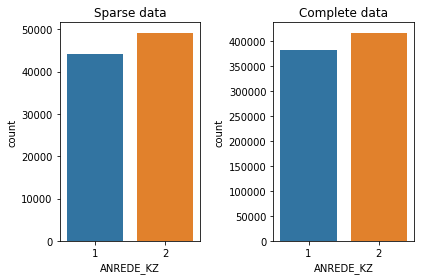

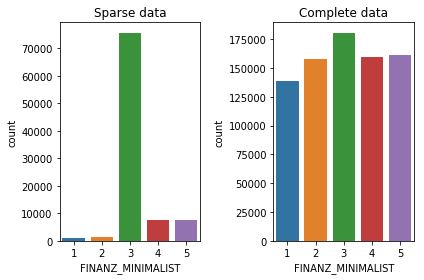

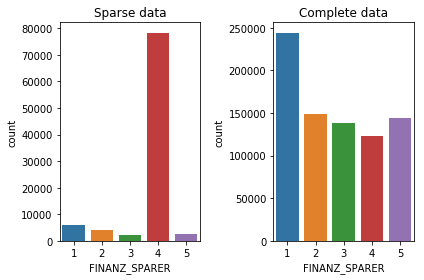

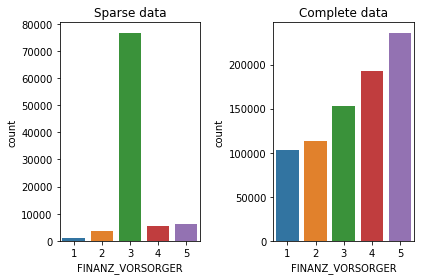

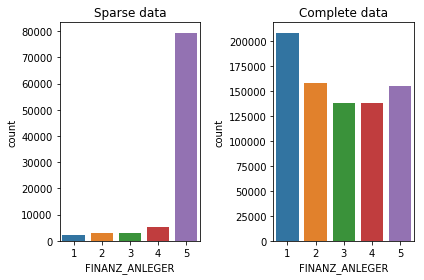

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for column in full_cols[0:5]:
    
    fig, ax =plt.subplots(1,2)
    sns.countplot(above_threshold[column], ax=ax[0])
    ax[0].set_title('Sparse data')
    
    sns.countplot(below_threshold[column], ax=ax[1])
    ax[1].set_title('Complete data')
    
    fig.tight_layout()
    fig.show()
    



#### Discussion 1.1.3: Assess Missing Data in Each Row


Reviewing the amount of data missing in the rows, we see that there are two clusters:
* Those with lots of data missing (at least 32% of each row)
* Those with few or no missing data

We compared the distributions of features for these two sub-populations and can see that they are distinctly different from each other. 

To minimise the amount of imputed data, we will apply PCA to the sub population with less than 32% missing row data. However the population with lots of missing data, will be treated as its own cluster later on in the project.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
print(azdias.shape) 
categorical_var = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical_var = [var for var in categorical_var if var in azdias.columns ]
categorical_var

(891221, 79)


['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_vars=[var for var in categorical_var if azdias[var].nunique()==2  ]
print(binary_vars)

multi_level_vars=[var for var in categorical_var if azdias[var].nunique()>2  ]
print(multi_level_vars)

for var in binary_vars:
    print(azdias[var].value_counts())

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [27]:
azdias['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace=True)
for var in binary_vars:
    print(azdias[var].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64


In [28]:
for var in multi_level_vars:
    print(azdias[var].value_counts())

4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STATUS_FEIN, dtype: int64
1.0    337511
2.0    226915
4.0    162946
5.0    118022
3.0     40973
Na

In [29]:
below_threshold['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace=True)

In [30]:
#Drop CAMEO_DEU_2015
below_threshold.drop(['CAMEO_DEU_2015'], axis=1,inplace=True)                                   

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi_level_vars=list(set(multi_level_vars)-set(['CAMEO_DEU_2015']))

below_threshold = pd.get_dummies(below_threshold, columns=multi_level_vars)


In [32]:
below_threshold.shape

(797961, 150)

#### Discussion 1.2.1: Re-Encode Categorical Features

We needed to remap only one of the binary categorical variables (OST_WEST_KZ) to give numerical classes. 

Reviewing the multilevel categorical variables we decided to remove CAMEO_DEU_2015 which gives the detail in CAMEO_DEUG_2015, but on a much finer scale. It's felt that this variable would increase the dimisensions of the dataset greatly without giving much extra insight.

All other categorical variables were encoded via the get_dummies function.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mainstream=[1,3,5,8,10,12,14]
avantgarde=[2,4,6,7,9,11,13,15]

def movement_mapping(x):
    if x in mainstream:
        return 0
    elif x in avantgarde:
        return 1
    else:
        return np.nan

forties=[1,2]
fifties=[3,4]
sixties=[5,6,7]
seventies=[8,9]
eighties=[10,11,12,13]
nineties=[14,15]    
def decade_mapping(x):
    if x in forties:
        return 40
    elif x in fifties:
        return 50
    elif x in sixties:
        return 60
    elif x in seventies:
        return 70
    elif x in eighties:
        return 80
    elif x in nineties:
        return 90
    else:
        return np.nan
    

In [34]:
# Create movement column
below_threshold['PRAEGENDE_JUGENDJAHRE_movement'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(movement_mapping)

# Create decade column
below_threshold['PRAEGENDE_JUGENDJAHRE_decade'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(decade_mapping)


In [35]:
below_threshold['PRAEGENDE_JUGENDJAHRE_movement'].value_counts()

0.0    594032
1.0    175220
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

In [36]:
below_threshold['PRAEGENDE_JUGENDJAHRE_decade'].value_counts()

90.0    225511
70.0    175182
80.0    151761
60.0    114349
50.0     74292
40.0     28157
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#below_threshold['CAMEO_INTL_2015'].value_counts()

below_threshold['CAMEO_INTL_2015_wealth'] = below_threshold['CAMEO_INTL_2015'].str[0]
below_threshold['CAMEO_INTL_2015_family'] = below_threshold['CAMEO_INTL_2015'].str[1]


In [38]:
below_threshold['CAMEO_INTL_2015_family'].value_counts()

1    245049
4    232768
3    119687
5    117040
2     77296
Name: CAMEO_INTL_2015_family, dtype: int64

In [39]:
below_threshold['CAMEO_INTL_2015_wealth'].value_counts()

5    223579
2    190674
4    189960
1    119438
3     68189
Name: CAMEO_INTL_2015_wealth, dtype: int64

In [40]:
#Looking at other mixed type variables
mixed_vars=feat_info[feat_info['type'] == 'mixed']['attribute'].values

mixed_vars = [var for var in mixed_vars if var in below_threshold.columns ]

mixed_vars

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [41]:
for_review=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

for var in for_review:
    print(below_threshold[var].value_counts())


1.0     58723
5.0     52400
6.0     43334
2.0     37149
8.0     28839
11.0    25374
7.0     24950
29.0    24881
13.0    24811
10.0    24476
12.0    22281
31.0    22261
30.0    21149
15.0    18967
3.0     18757
19.0    18586
37.0    17500
4.0     16478
14.0    16355
20.0    16287
32.0    15765
39.0    15132
40.0    14109
27.0    13805
16.0    13634
38.0    13100
35.0    13012
34.0    12422
9.0     12112
21.0    11967
28.0    11547
24.0    11311
25.0     9850
36.0     9657
23.0     8631
22.0     6831
18.0     6806
33.0     5724
17.0     5487
26.0     3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64
2.0     149523
1.0     131107
3.0     109688
12.0     69498
4.0      51208
5.0      47166
9.0      46030
10.0     38026
11.0     31158
8.0      28720
6.0      27429
7.0      21161
Name: LP_LEBENSPHASE_GROB, dtype: int64
3.0    249702
7.0    169306
4.0    135960
2.0    100366
5.0     74339
1.0     43914
8.0     17464
0.0      6910
Name: WOHNLAGE, dtype: int64
1.0    499550
5.0     97333
2.0     704

In [42]:
below_threshold = below_threshold.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PLZ8_BAUMAX'], axis=1)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are six mixed-type features. These are:
* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* WOHNLAGE
* PLZ8_BAUMAX
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB

We engineered two new variables from PRAEGENDE_JUGENDJAHRE: one for decade and one for movement.
Similarly, we engineered two new variables from CAMEO_INTL_2015: one for wealth and one for family life stage.

Of the remaining variable, we decided to keep only WOHNLAGE as the others looked similar to variables that were already in the dataset we are carrying forward to do PCA on.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')


In [46]:
columns_high_missings=['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']

mainstream=[1,3,5,8,10,12,14]
avantgarde=[2,4,6,7,9,11,13,15]

def movement_mapping(x):
    if x in mainstream:
        return 0
    elif x in avantgarde:
        return 1
    else:
        return np.nan

forties=[1,2]
fifties=[3,4]
sixties=[5,6,7]
seventies=[8,9]
eighties=[10,11,12,13]
nineties=[14,15]    
def decade_mapping(x):
    if x in forties:
        return 40
    elif x in fifties:
        return 50
    elif x in sixties:
        return 60
    elif x in seventies:
        return 70
    elif x in eighties:
        return 80
    elif x in nineties:
        return 90
    else:
        return np.nan
    
columns_to_drop2=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PLZ8_BAUMAX','CAMEO_DEU_2015']



In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for attribute in feat_info['attribute']:
        missing_or_unknown_vals=feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0]

        missing_or_unknown_list=missing_or_unknown_vals.strip('[ ]').split(',')

        null_vals=[]
        for item in missing_or_unknown_list: 
            if item.lstrip('-').isnumeric():
                null_vals.append(float(item))
            else:
                null_vals.append(item)

        df[attribute].replace(to_replace=null_vals,value=np.nan,inplace=True)
    
    # remove selected columns and rows, ...
    
    # drops the columns identified in the general population as having greater than 20% missing
    df = df.drop(columns_high_missings, axis=1)
    
    # drop rows from the dataset where greater than 32% of the data is missing
    df_copy=df.copy()
    
    sum_of_missings=df.isnull().sum(axis=1)
    pc_of_missings=100 * df.isnull().sum(axis=1) / (df.shape[1])
    missings_tab = pd.concat([sum_of_missings, pc_of_missings], axis=1)
    missings_df = missings_tab.rename(columns = {0 : 'Count', 1 : 'Percent'})

    missings_df = missings_df[missings_df.iloc[:,1] != 0].sort_values(
        'Percent', ascending=False).round(2)

    missings_df = missings_df[missings_df.iloc[:,1] != 0].sort_values(
        'Percent', ascending=False).round(2)
    high_missings=missings_df[missings_df.Percent >= 32.].index
    above_threshold=df.take(df.index[high_missings])
    below_threshold=df.drop(df.index[high_missings])
    
    # select, re-encode, and engineer column values.
    
    #re-encode binary variable
    below_threshold['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace=True)
    
    categorical_var = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_var = [var for var in categorical_var if var in below_threshold.columns ]
    
    multi_level_vars=[var for var in categorical_var if below_threshold[var].nunique()>2  ]
    
    multi_level_vars=list(set(multi_level_vars)-set(['CAMEO_DEU_2015']))
    
    
    
    below_threshold = pd.get_dummies(below_threshold, columns=multi_level_vars)
    
    
    
    
    # Create movement column
    below_threshold['PRAEGENDE_JUGENDJAHRE_movement'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(movement_mapping)

    # Create decade column
    below_threshold['PRAEGENDE_JUGENDJAHRE_decade'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(decade_mapping)

    # Create wealth column
    below_threshold['CAMEO_INTL_2015_wealth'] = below_threshold['CAMEO_INTL_2015'].str[0]

    # Create family column
    below_threshold['CAMEO_INTL_2015_family'] = below_threshold['CAMEO_INTL_2015'].str[1]
    
    # drops surplus mixes columns we don't want to model on
    
    cleaned_data = below_threshold.drop(columns_to_drop2, axis=1)
    
    return cleaned_data, above_threshold, below_threshold
    

In [48]:
cleaned_data, above_threshold, below_threshold=clean_data(azdias)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
cleaned_data, above_threshold, below_threshold=clean_data(azdias)



As I'm using sklearn version 0.19.1, SimpleImputer isn't available from sklearn.impute, therefore I'm using Imputer from sklearn.preprocessing instead.



In [50]:

from sklearn.preprocessing import Imputer

imp = Imputer()
imp = imp.fit(cleaned_data)

cleaned_imputed_data = imp.transform(cleaned_data)


In [51]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(cleaned_imputed_data)
new_data= scaler.transform(cleaned_imputed_data)


### Discussion 2.1: Apply Feature Scaling

We used the imputer() function to replace missing values and followed up with StandardScaler() which transforms the columns to have a mean value of 0 and standard deviation of 1. 

Note: as we are using sklearn version 0.19.1, SimpleImputer isn't available from sklearn.impute. Therefore we're using Imputer from sklearn.preprocessing instead, despite this being deprecated in later versions of sklearn.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=75)
X_pca = pca.fit_transform(new_data)
X_pca

array([[ 4.9162419 , -3.67776628, -3.12070019, ...,  0.90514493,
        -1.51719331,  0.44763118],
       [-0.12290541, -0.50391498, -3.16087418, ..., -0.38543502,
        -0.45917807,  0.52056226],
       [-4.82069814,  1.49484873, -1.44152055, ...,  0.55553276,
         0.19201989,  1.12511044],
       ..., 
       [-0.54985403, -3.98179048, -3.40968692, ..., -0.45303184,
         0.48696908, -0.83790673],
       [ 6.24670689, -4.25534868,  2.7188105 , ..., -0.03351186,
        -0.24067543,  0.43544898],
       [ 0.60687581,  2.6576705 ,  2.14982738, ...,  0.98181463,
        -1.08608211,  0.13160477]])

### Reference
The code in the next cell is taken directly from the helper functions file used in the PCA mini project, with some minor format changes to try and make the graph more readable.

In [53]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    
    plt.figure(figsize=(20, 15))
    #plt.tight_layout()
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.autoscale(enable=True, axis='both', tight=True)
    ax.plot(ind, cumvals)
    
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),xytext=(0, 3),
                    textcoords="offset points", va="bottom", ha="center", rotation=90, fontsize=9)
  
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    return num_components,ind,vals


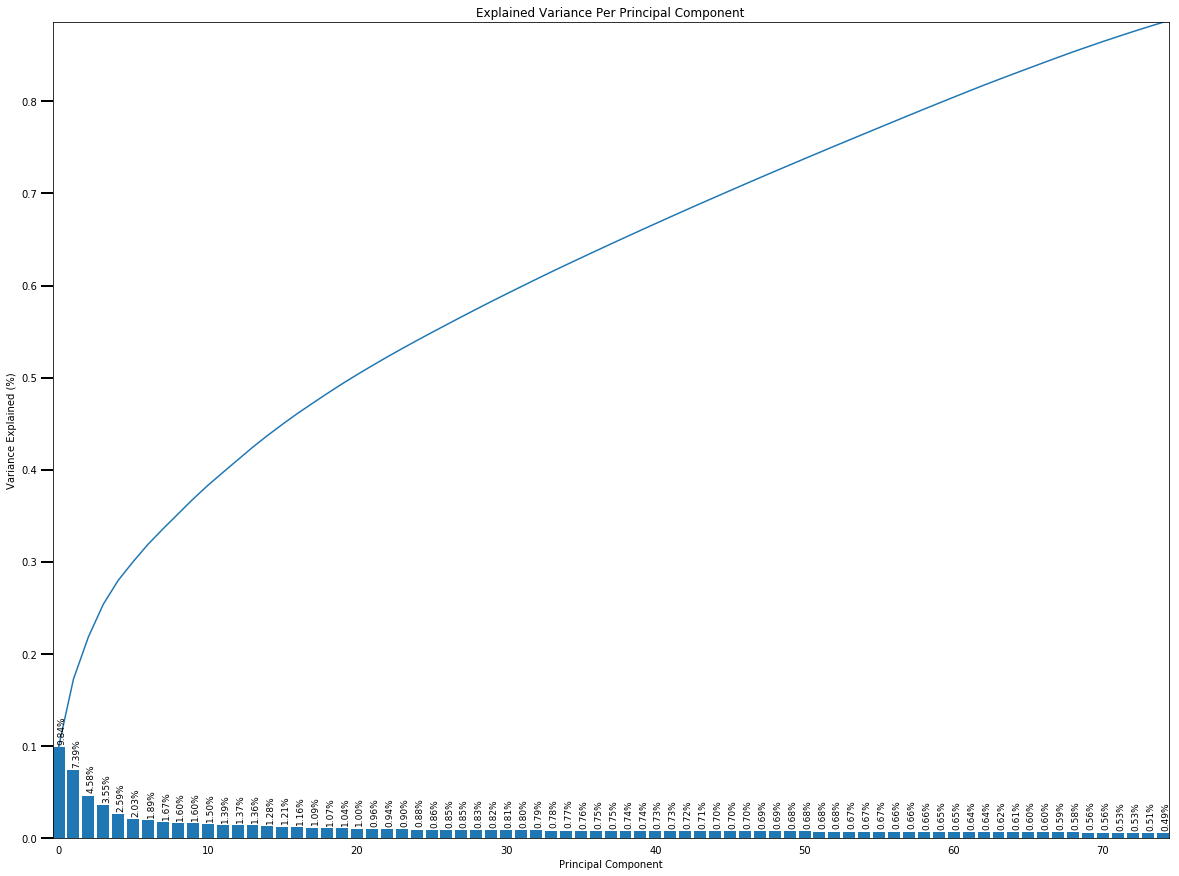

In [54]:
num_components,ind,vals=scree_plot(pca)

In [55]:
# Percentage of variance explained by the above graph
pca.explained_variance_ratio_.sum()

0.88582398672679263

In [56]:
# Investigate the variance accounted for by each principal component.

components = [i for i in range(1,num_components+1)] 
cum_vals=np.cumsum(pca.explained_variance_ratio_)

df=pd.concat([pd.Series(components), pd.Series(vals),pd.Series(cum_vals)], axis = 1)
df.rename(columns={0:'Component number',1:'variance captured in component',2:'cumulative variance captured'}, inplace=True)
df[0:50]

,Component number,variance captured in component,cumulative variance captured
0,1,0.098400,0.098400
1,2,0.073977,0.172377
2,3,0.045813,0.218190
3,4,0.035562,0.253752
4,5,0.025919,0.279672
5,6,0.020308,0.299980
6,7,0.018906,0.318886
7,8,0.016723,0.335609
8,9,0.016083,0.351691
9,10,0.016042,0.367733


In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=46) # this captures c.70% of the variance
X_pca_reduced = pca.fit_transform(new_data)


pca.explained_variance_ratio_.sum()


0.69875854248652092

### Discussion 2.2: Perform Dimensionality Reduction

From the above analysis, with PCA we can reduce the number of dimensions from 149 to 46 and still capture c.70% of the variance in the original dataset



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(dataset, pca, comp_index):
    '''
	Create a DataFrame of the highest three and bottom three feature weights for a specific component
	'''
    
    #comp_index=component_num-1
    components = pd.DataFrame(np.round(pca.components_, 4), columns = dataset.keys()).iloc[comp_index]
    components.sort_values(ascending=False, inplace=True)
    
    significant_vars=pd.concat([components.head(5),components.tail(5)])
    
    return significant_vars

pca_weights(cleaned_data, pca, 0)

LP_STATUS_GROB_1.0        0.2004
HH_EINKOMMEN_SCORE        0.1869
PLZ8_ANTG3                0.1844
CAMEO_INTL_2015_wealth    0.1820
PLZ8_ANTG4                0.1785
PLZ8_ANTG1               -0.1841
KBA05_GBZ                -0.1843
KBA05_ANTG1              -0.1937
FINANZ_MINIMALIST        -0.1995
MOBI_REGIO               -0.2070
Name: 0, dtype: float64

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(cleaned_data, pca, 1)

ALTERSKATEGORIE_GROB            0.2302
FINANZ_VORSORGER                0.2165
ZABEOTYP_3                      0.2002
SEMIO_ERL                       0.1793
SEMIO_LUST                      0.1617
SEMIO_TRADV                    -0.2061
SEMIO_REL                      -0.2118
FINANZ_UNAUFFAELLIGER          -0.2133
FINANZ_SPARER                  -0.2225
PRAEGENDE_JUGENDJAHRE_decade   -0.2353
Name: 1, dtype: float64

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(cleaned_data, pca, 2)

SEMIO_VERT     0.3188
SEMIO_FAM      0.2607
SEMIO_SOZ      0.2572
SEMIO_KULT     0.2518
FINANZTYP_5    0.1364
SEMIO_ERL     -0.2081
SEMIO_KRIT    -0.2670
SEMIO_DOM     -0.2825
SEMIO_KAEM    -0.3144
ANREDE_KZ     -0.3451
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

### Principal Component 1 (comp_ind=0)
This component is most positively associated with:
* LP_STATUS_GROB_2.0           Social status(low earners)
* HH_EINKOMMEN_SCORE           Estimated household net income - higher values for lower incomes     
* PLZ8_ANTG3                   Number of 6-10 family houses - higher values for more houses
* CAMEO_INTL_2015_wealth       Wealth typology - higher values for poorer households
* PLZ8_ANTG4                   Number of 10+ family houses in the PLZ8 region - higher values for more houses 

This component is most negatively associated with:
* PLZ8_ANTG1                   Number of 1-2 family houses - lower values for fewer numbers
* KBA05_GBZ                    Number of buildings in the microcell - lower values for fewer houses
* KBA05_ANTG1                  Number of 1-2 family houses in the microcell - lower values for fewer numbers of these houses
* FINANZ_MINIMALIST            Financial typology(low financial interest)
* MOBI_REGIO                   Movement patterns -lower values for higher amounts of movement

**Interpretation:**
Low earners who move a lot; living in areas with large family houses and fewer small houses; probably young professionals/students although there aren't any age related characteristics to back this up.




### Principal Component 2 (comp_ind=1)
This component is most positively associated with:
* ALTERSKATEGORIE_GROB               Estimated age based on given name analysis - higher values for older age 
* FINANZ_VORSORGER                   Financial typology(be prepared) 
* ZABEOTYP_3                         Energy consumption typology (fair supplied)  
* SEMIO_ERL                          Personality typology (event-oriented)
* SEMIO_LUST                         Personality typology (sensual-minded)

This component is most negatively associated with:

* SEMIO_TRADV                        Personality typology (sensual-minded)
* SEMIO_REL                          Personality typology (religious)
* FINANZ_UNAUFFAELLIGER              Financial typology (tradional-minded)
* FINANZ_SPARER                      Financial typology (money-saver)
* PRAEGENDE_JUGENDJAHRE_decade       Lifestage typology - lower values for older generation

**Interpretation of component 2:**
Older population; preparing for retirement, but not doing without; open to a more hedonistic lifestyle than traditional




### Principal Component 3 (comp_ind=2)
This component is most positively associated with:  
* SEMIO_VERT    Personality typology (dreamful)
* SEMIO_FAM     Personality typology (family-minded) 
* SEMIO_SOZ     Personality typology (socially-minded)
* SEMIO_KULT    Personality typology (cultural-minded)
* FINANZTYP_5   Financial type (investor) 

This component is most negatively associated with:
* SEMIO_ERL     Personality typology (event-oriented)
* SEMIO_KRIT    Personality typology (critical-minded) 
* SEMIO_DOM     Personality typology (dominant-minded)
* SEMIO_KAEM    Personality typology (combative attitude)   
* ANREDE_KZ     Gender - higher value for more male population  

**Interpretation of component 3:**
Predominately female population; family oriented with a social conscience; opposed to aggression or activism.






## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

### Reference
The clustering_errors function is is taken from the helper funtions used in the k-means Clustering of Movie Ratings Lab.

In [61]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
def clustering_errors(k, data):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=1234).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    # compute the average within-cluster distances.
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)


Clustering for k=10 done
Clustering for k=11 done
Clustering for k=12 done
Clustering for k=13 done
Clustering for k=14 done
Clustering for k=15 done
Clustering for k=16 done
Clustering for k=17 done
Clustering for k=18 done
Clustering for k=19 done
Clustering for k=20 done
Clustering for k=21 done
Clustering for k=22 done
Clustering for k=23 done
Clustering for k=24 done
Clustering for k=25 done
Clustering for k=26 done
Clustering for k=27 done
Clustering for k=28 done
Clustering for k=29 done


Text(0.5,1,'MSE vs. k')

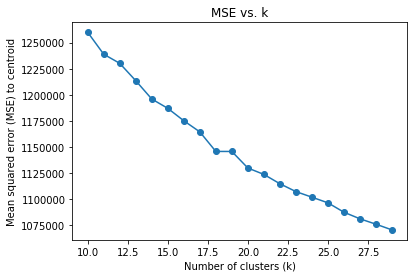

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Choose the range of k values to test.
# We added a stride of 3 to improve performance. We don't need to calculate the error for every k value

possible_k_values = range(10, 30, 1)

# Calculate error values for all k values we're interested in
errors=[]
for k in possible_k_values:
    k_error=clustering_errors(k, X_pca_reduced)
    errors.append(k_error)
    
    print("Clustering for k={} done".format(k))


#fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors,'-o')
plt.ylabel('Mean squared error (MSE) to centroid')
plt.xlabel('Number of clusters (k)')
plt.title("MSE vs. k")




In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k=18

kmeans=KMeans(k, random_state=1234)
cluster_pred = kmeans.fit_predict(X_pca_reduced)


In [65]:
df_2=pd.Series(cluster_pred).to_frame()

df_2[0].value_counts()


1     77345
6     76052
8     75353
3     67458
14    57552
13    53317
17    47818
4     47280
10    44426
12    40750
5     39625
2     35111
16    33036
9     30507
7     25962
15    24414
11    18518
0      3437
Name: 0, dtype: int64

### Discussion 3.1: Apply Clustering to General Population

We ran KMeans clustering over the entire population for all integer values of k between 10 and 30. Comparing the sum of the mean squared error for each of the different clusterings, there is a clear elbow point at k=18.Therefore we will choose this for the number of clusters going forward.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [67]:

cust_cleaned_data, cust_above_threshold, cust_below_threshold=clean_data(customers)

list(set(cleaned_data.columns)-set(cust_cleaned_data.columns))
cust_cleaned_data['GEBAEUDETYP_5.0']=0
#cust_cleaned_data

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cust_cleaned_imputed_data = imp.transform(cust_cleaned_data)
cust_new_data= scaler.transform(cust_cleaned_imputed_data)

X_pca_cust = pca.transform(cust_new_data)



In [69]:
cust_cluster_pred = kmeans.predict(X_pca_cust)
cust_cluster_pred

array([14, 14, 14, ..., 14,  5,  5], dtype=int32)

In [70]:
df_3=pd.Series(cust_cluster_pred).to_frame()

df_3[0].value_counts()
#df_3.shape

5     77274
14    60809
0      2347
6       293
3       191
8       154
1       143
15      108
10       84
12       80
17       59
11       57
4        55
9        39
16        8
13        5
2         4
7         3
Name: 0, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

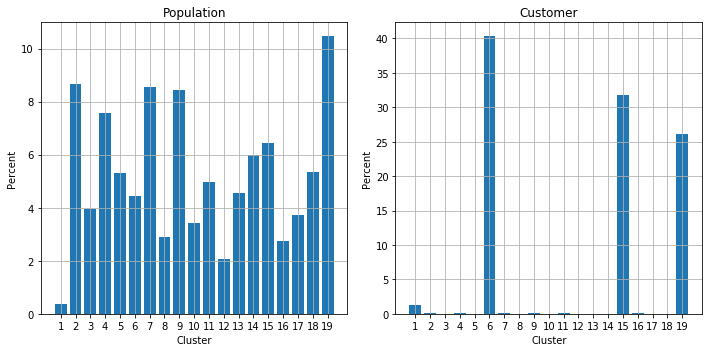

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_df=pd.Series(cust_cluster_pred).to_frame()
cust_array=pd.Series(cust_df[0].value_counts().sort_index())
# Append missings from customer dataset to make them a new cluster
cust_missings=pd.Series(cust_above_threshold.shape[0]).rename({0:18})
cust_array=cust_array.append(cust_missings)


pop_df=pd.Series(cluster_pred).to_frame()
pop_array=pd.Series(pop_df[0].value_counts().sort_index())
# Append missings from population dataset to make them a new cluster
pop_missings=pd.Series(above_threshold.shape[0]).rename({0:18})
pop_array=pop_array.append(pop_missings)
both_array=pd.concat([cust_array,pop_array],axis=1)


both_array.columns=['customer','population']
both_array['cluster']=both_array.index+1
both_array['customer_percent']=(both_array['customer']/both_array['customer'].sum())*100
both_array['population_percent']=(both_array['population']/both_array['population'].sum())*100
both_array

fig, axes = plt.subplots(1,2,figsize=(10, 5))
ax1=plt.subplot(1,2,1)
plt.bar(both_array['cluster'],both_array['population_percent'])

ax2=plt.subplot(1,2,2)
plt.bar(both_array['cluster'],both_array['customer_percent'])


ax1.grid(True)
ax1.set_title('Population')
ax1.set_ylabel('Percent')
ax1.set_xlabel('Cluster')
ax1.set_xticks(range(1,20,1))



ax2.grid(True)
ax2.set_title('Customer')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Cluster')
ax2.set_xticks(range(1,20,1))

fig.tight_layout()

In [76]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#6th cluster i.e. cluster 5 is overrepresented

#Find the top 3/bottom 3 principal components associated with cluster 5
clus_center=kmeans.cluster_centers_[5]
clus_center=pd.Series(clus_center)
clus_center.sort_values(ascending=False,inplace=True)
print(clus_center.head(3))

print(clus_center.tail(3))


3     3.498787
2     1.290423
14    0.787958
dtype: float64
7   -1.374649
1   -2.132759
0   -3.854082
dtype: float64


In [77]:
pca_weights(cust_cleaned_data, pca, 3)


PRAEGENDE_JUGENDJAHRE_decade    0.2945
GREEN_AVANTGARDE                0.2942
FINANZTYP_1                     0.2475
LP_STATUS_FEIN_10.0             0.2475
EWDICHTE                        0.2099
INNENSTADT                     -0.1655
BALLRAUM                       -0.1686
LP_STATUS_FEIN_9.0             -0.1758
LP_STATUS_GROB_5.0             -0.1867
WOHNLAGE                       -0.2156
Name: 3, dtype: float64

In [78]:
pca_weights(cust_cleaned_data, pca, 2)

SEMIO_VERT     0.3188
SEMIO_FAM      0.2607
SEMIO_SOZ      0.2572
SEMIO_KULT     0.2518
FINANZTYP_6    0.1364
SEMIO_ERL     -0.2081
SEMIO_KRIT    -0.2670
SEMIO_DOM     -0.2825
SEMIO_KAEM    -0.3144
ANREDE_KZ     -0.3451
Name: 2, dtype: float64

### Overrepresented cluster expression in 4th Principal Component (comp_ind=3)
This component is most positively associated with:
* PRAEGENDE_JUGENDJAHRE_decade    Decade of birth - higher values for younger people     
* GREEN_AVANTGARDE                Membership in environmental sustainability as part of youth
* FINANZTYP_1                     Financial type (low financial interest)
* LP_STATUS_FEIN_10.0             Social status (top earners)           
* EWDICHTE                        Density of households per square kilometer - higher values for more dense               
This component is most negatively associated with:
* INNENSTADT                      Distance to city center - lower values for closer to town centre
* BALLRAUM                        Distance to nearest urban center - lower values for closer to town centre
* LP_STATUS_FEIN_9.0              Social status (houseowners)
* LP_STATUS_GROB_5.0              Social status (top earners)
* WOHNLAGE                        Neighborhood quality - lower for better neighbourhoods

**Interpretation:**
Younger population; interested in sustainability and environmentalism; living in dense urban areas. It's very unclear regarding the income of this group as there appears to be evidence of being a top earner is both positively and negatively asscociated to this population.

### Overrepresented cluster expression in 3rd Principal Component (comp_ind=2)

This component is most positively associated with:
* SEMIO_VERT    Personality typology (dreamful)
* SEMIO_FAM     Personality typology (family-minded) 
* SEMIO_SOZ     Personality typology (socially-minded)
* SEMIO_KULT    Personality typology (cultural-minded)
* FINANZTYP_6   Financial type (inconspicuous) 
This component is most negatively associated with:
* SEMIO_ERL     Personality typology (event-oriented)
* SEMIO_KRIT    Personality typology (critical-minded) 
* SEMIO_DOM     Personality typology (dominant-minded)
* SEMIO_KAEM    Personality typology (combative attitude)   
* ANREDE_KZ     Gender - higher value for more male population        

**Interpretation:**
Predominantly female population, idealistic and caring, family oriented personality, opposed to aggression or activism.



In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#2nd cluster i.e. cluster 1 is overrepresented

#Find the top 3/bottom 3 principal components associated with cluster 1
clus_center=kmeans.cluster_centers_[1]
clus_center=pd.Series(clus_center)
clus_center.sort_values(ascending=False,inplace=True)
print(clus_center.head(3))

print(clus_center.tail(3))


0    2.845861
1    2.660514
2    2.644120
dtype: float64
5    -0.447155
13   -0.749179
3    -0.757286
dtype: float64


In [80]:
pca_weights(cust_cleaned_data, pca, 0)

LP_STATUS_GROB_2.0        0.2004
HH_EINKOMMEN_SCORE        0.1869
PLZ8_ANTG3                0.1844
CAMEO_INTL_2015_family    0.1820
PLZ8_ANTG4                0.1785
PLZ8_ANTG1               -0.1841
KBA05_GBZ                -0.1843
KBA05_ANTG1              -0.1937
FINANZ_MINIMALIST        -0.1995
MOBI_REGIO               -0.2070
Name: 0, dtype: float64

In [81]:
pca_weights(cust_cleaned_data, pca, 1)

ALTERSKATEGORIE_GROB      0.2302
FINANZ_VORSORGER          0.2165
ZABEOTYP_3                0.2002
SEMIO_ERL                 0.1793
SEMIO_LUST                0.1617
SEMIO_TRADV              -0.2061
SEMIO_REL                -0.2118
FINANZ_UNAUFFAELLIGER    -0.2133
FINANZ_SPARER            -0.2225
CAMEO_INTL_2015_wealth   -0.2353
Name: 1, dtype: float64

### Underrepresented cluster expression in 1st Principal Component (comp_ind=0)
This component is most positively associated with:
* LP_STATUS_GROB_2.0           Social status(average earners)
* HH_EINKOMMEN_SCORE           Estimated household net income - higher values for lower incomes     
* PLZ8_ANTG3                   Number of 6-10 family houses - higher values for more houses
* CAMEO_INTL_2015_family       Family stage - higher values for more mature family
* PLZ8_ANTG4                   Number of 10+ family houses in the PLZ8 region - higher values for more houses 
This component is most negatively associated with:
* PLZ8_ANTG1                   Number of 1-2 family houses - lower values for fewer numbers
* KBA05_GBZ                    Number of buildings in the microcell - lower values for fewer houses
* KBA05_ANTG1                  Number of 1-2 family houses - lower values for fewer numbers of these houses
* FINANZ_MINIMALIST            Financial typology(low financial interest)
* MOBI_REGIO                   Movement patterns -lower values for higher amounts of movement

**Interpretation:**
Average earners with grown-up families; probably still living in a large family home; has moved around a lot

### Underrepresented cluster expression in 2nd Principal Component (comp_ind=1)
This component is most positively associated with:
* ALTERSKATEGORIE_GROB               Estimated age based on given name analysis - higher values for older age 
* FINANZ_VORSORGER                   Financial typology(be prepared) 
* ZABEOTYP_3                         Energy consumption typology (fair supplied)  
* SEMIO_ERL                          Personality typology (event-oriented)
* SEMIO_LUST                         Personality typology (sensual-minded)

This component is most negatively associated with:

* SEMIO_TRADV                        Personality typology (traditional)
* SEMIO_REL                          Personality typology (religious)
* FINANZ_UNAUFFAELLIGER              Financial typology (inconspicuous)
* FINANZ_SPARER                      Financial typology (money-saver)
* CAMEO_INTL_2015_wealth             Wealth typology - lower values for wealthier households 

**Interpretation:**
Older, wealthy population; preparing for retirement, but not doing without; open to a sensual, experience-filled lifestyle than traditional.

     




### Discussion 3.3: Compare Customer Data to Demographics Data

From the analysis above, we've identified the strongest cluster in the customer dataset is the younger, more mobile audience of predominantly students/young professionals, living in high density areas, who are interested in sustainability and environmentalism; idealistic and family oriented.

From the analysis above, we've identified the strongest cluster in the customer dataset is the younger, more mobile audience of predominantly students/young professionals, living in high density areas, who are interested in sustainability and environmentalism; idealistic and family oriented. This population makes up c.40% of the mail-order company's customer base, whereas it only attributes to 4% of the general population. 

One particular audience that the company aren't attracting are the older average to high-earners who are nearing retirement with grown up families of their own; not big spenders, but open to a more sensual lifestyle than traditional. 

Making a slight change to the marketing of the company towards this latter audience may pay big dividends as it makes up for 8% of the general population.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.